<a name="TOC"></a>
## Table of contents

### <a href="#EDA">1. EDA</a>

 - <a href="#MCC">Multicollinearity and correlations</a>
 - <a href="#data_dist">Check data distribuitions</a>

### <a href="#prep">2. Preprocessing</a>

 - <a href="#TTS">Train test split</a>
 - <a href="#OHE">One-hot-encoding</a>
 - <a href="#scaling">Scaling</a>
 - <a href="#list_mod">Craete lists to add models and reports</a>
 
###  <a href="#apl_models">3. Applying different models</a>

 - <a href="#baseline">Baseline: guessing majority class</a>
 - <a href="#lr_all">LR on all features</a>
 - <a href="#sm">Compare with StatsModels</a>
 - <a href="#lr_limited">LR with the coefficients that have p-values < 0.05</a>
 - <a href="#rf1">Random Forests</a>
 - <a href="#xgb1">XGBoost</a>
 - <a href="#gb1">Gradient Boosting</a>
 
### <a href="#c_imb_rej">4. Correcting class imbalance with rejected dataset</a>

 - <a href="#rf2">Random Forests</a>
 - <a href="#lr_rej">LR</a> 
 - <a href="#gb2">Gradient Boosting</a>
 - <a href="#xgb2">XGBoost</a>
 
### <a href="#c_imb_res">5. Correcting class imbalance through resampling</a>

 - <a href="#rf3">Random Forests</a>
 - <a href="#gb3">Gradient Boosting</a>
 - <a href="#xgb3">XGBoost</a>
 - <a href="#lr_res">LR</a> 
 
### <a href="#comparison">6. Models comparison</a>
 
### <a href="#explore">7. Further exploration of the selected Logistic Regression model (lr4)</a>
 
 - <a href="#metrics">Cross-validated log loss and AUC</a>
 - <a href="#thres_val">Threshold variation</a>
 - <a href="#roc_vis">ROC-AUC visualization</a>
 - <a href="#coef">Model coefficients</a>
  
### <a href="#pred">8. Making predictions with lr4 model</a>
 
### <a href="#check_calib">9. Checking lr4 model's calibation</a>
 - <a href="#calib">Check model's calibration of training and testing set</a>
 - <a href="#cv_calib">Cross-validate calibration</a>
 - <a href="#plot_calib">Plot cross-validated calibration</a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline, FeatureUnion, Pipeline
from sklearn.preprocessing import OneHotEncoder, Imputer, StandardScaler
import random
import seaborn as sns
from sklearn_pandas.pipeline import Pipeline
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from functions import (ohe, logireg, gb, xgb, rf, predict_probability_and_class, check_calibration,
                       keep_states_drop, preprocess, scale_columns, parse_reports, get_df_coef,
                      cv_calibration, guess_maj_class_cv_auc)
from sklearn.metrics import (roc_curve, auc, precision_recall_curve, make_scorer, 
recall_score, accuracy_score, precision_score, confusion_matrix)

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.utils import resample
import pickle
import scikitplot as skplt
from plr.predict import predict_p

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
#had to install xgboost
#!pip install xgboost

### Load data

In [3]:
df_approved = pd.read_csv('data/approved_loan_data.csv', index_col=False)
df_rejected = pd.read_csv('data/rejected_loan_data.csv', index_col=False)

<div style="float:left"><a href="#TOC">Table of contents</a></div>
<a name="EDA"></a>

# 1. EDA

In [4]:
len(df_approved)

4145

In [5]:
len(df_rejected)

2927

In [6]:
#How many loans were returned?

df_approved['status'].value_counts()

1    3317
0     828
Name: status, dtype: int64

### 75% of application from the approved set were paid pack

In [7]:
#Are the 2 dataframes's columns similar?

df_rejected.columns == df_approved.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [8]:
#What are the columns in the dataframes?
df_approved.columns

Index(['Unnamed: 0', 'monthly_income', 'gig_economy_weekly_income',
       'atm_check_deposits_weekly_income', 'direct_deposit_weekly_income',
       'government_aid_weekly_income', 'frequency_heuristic_weekly_income',
       'large_deposits_weekly_income', 'income_length', 'payrolls_per_month',
       'income_sources', 'days_since_most_recent_payroll',
       'days_until_next_payroll', 'bank_balance', 'overdraft_transactions',
       'nsf_transactions', 'return_transactions', 'reverse_transactions',
       'length_of_transaction_history', 'mortgage', 'auto_loan',
       'student_loan', 'traditional_single_payment', 'installment_loan',
       'predatory_installment_loan', 'title_loan', 'pay_advances',
       'total_loan_payments', 'no_of_other_active_loans',
       'traditional_single_payment_mean', 'traditional_single_payment_trend',
       'loan_amount', 'loan_requested', 'loan_borrowed_inc',
       'loan_outstanding_inc', 'state', 'loan_id', 'status'],
      dtype='object')

In [9]:
df_approved.shape

(4145, 38)

In [10]:
df_approved.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4145 entries, 0 to 4144
Data columns (total 38 columns):
Unnamed: 0                           4145 non-null int64
monthly_income                       4145 non-null float64
gig_economy_weekly_income            4145 non-null float64
atm_check_deposits_weekly_income     4145 non-null float64
direct_deposit_weekly_income         4145 non-null float64
government_aid_weekly_income         4145 non-null float64
frequency_heuristic_weekly_income    4145 non-null float64
large_deposits_weekly_income         4145 non-null float64
income_length                        4145 non-null int64
payrolls_per_month                   4145 non-null float64
income_sources                       4145 non-null int64
days_since_most_recent_payroll       4145 non-null int64
days_until_next_payroll              4145 non-null int64
bank_balance                         4145 non-null float64
overdraft_transactions               4145 non-null int64
nsf_transactions    

There are no null values and all essential data is numeric, which helps a lot with the analysis process.

In [11]:
df_rejected.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2927 entries, 0 to 2926
Data columns (total 38 columns):
Unnamed: 0                           2927 non-null int64
monthly_income                       2927 non-null float64
gig_economy_weekly_income            2927 non-null float64
atm_check_deposits_weekly_income     2927 non-null float64
direct_deposit_weekly_income         2927 non-null float64
government_aid_weekly_income         2927 non-null float64
frequency_heuristic_weekly_income    2927 non-null float64
large_deposits_weekly_income         2927 non-null float64
income_length                        2927 non-null int64
payrolls_per_month                   2927 non-null float64
income_sources                       2927 non-null int64
days_since_most_recent_payroll       2927 non-null int64
days_until_next_payroll              2927 non-null int64
bank_balance                         2927 non-null float64
overdraft_transactions               2927 non-null int64
nsf_transactions    

There are null values only in 'state' column. Essential data is numeric

I decided to drop states that do not apperar in approved datasets and rejected dataset together. The idea is to be able to test the rejected dataset on the model created with approved application. I will also drop rows in rejected application where state is not specified.

<div style="float:left"><a href="#TOC">Table of contents</a></div>
<a name="MCC"></a>

### Multicollinearity and correlations

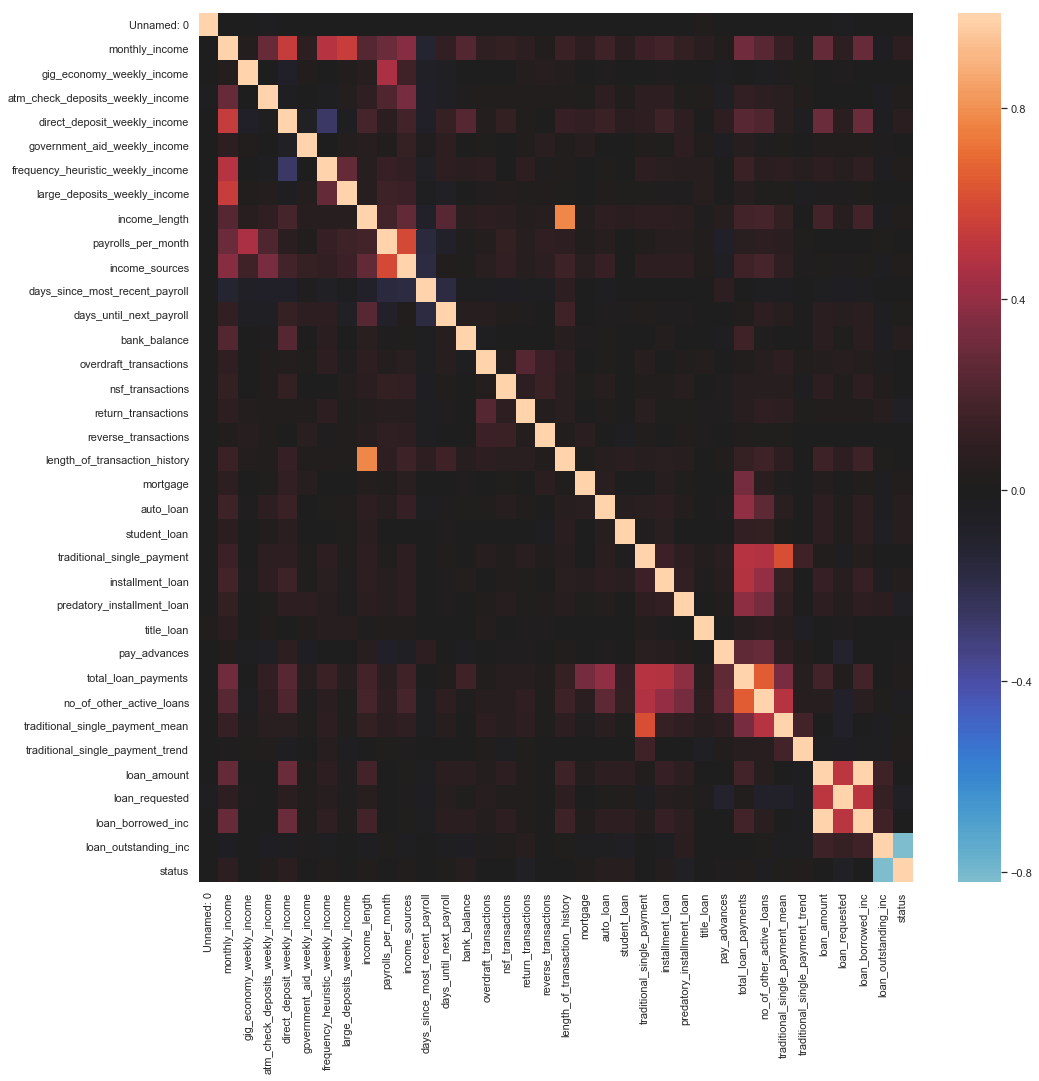

In [12]:
sns.set(rc={'figure.figsize':(16,16)})
sns.heatmap(df_approved.corr(), center=0);

It is clear that there is some data that reflects event after granting the loan ('loan_amount', 'loan_borrowed', etc.).

There is also hight correlations between length of income and length of transaction history, which asre clearly connected.

In [13]:
#search where correlation is greater than 0.7
correlations = df_approved.corr().applymap(lambda x: 'yes' if (abs(x) > 0.7) else x)
dfs = []
for name in correlations.columns:
    if len(correlations.loc[correlations[name]=='yes']) > 1:
        dfs.append(correlations.loc[correlations[name]=='yes'])
len(dfs)  #6      
# I checked all dfs to see where are the correlations
# dfs[5].T

6

Apart from obvious correlation between features that describe loan after it was granted, the high correlation between `income_length` and `length_of_transaction_history` was confirmed.

<div style="float:left"><a href="#TOC">Table of contents</a></div>
<a name="data_dist"></a>

### Check data distributions

In [14]:
#Cannot print out the result for the reasons of confidentiality

#df_approved.hist();

Distribution is a bit confusing because of the scale of many variables. Some seem to have only 0 values, but it is not the case, as small values are not seen in the histograms.

<div style="float:left"><a href="#TOC">Table of contents</a></div>
<a name="prep"></a>

# 2. Preprocessing

1. Drop `Unnamed: 0`, `loan_id` columns
2. Drop columns asocciated with granting the loan: `loan_amount`, `loan_borrowed_inc`, `loan_outstanding_inc`
3. Drop `length_of_transaction_history` because of correlation with `income_length`
2. Leave only states: 'LA', 'NH', 'NJ', 'ND'

In [15]:
df_approved = preprocess(df_approved)
df_rejected = preprocess(df_rejected)

<div style="float:left"><a href="#TOC">Table of contents</a></div>
<a name="TTS"></a>

### Train test split
I will work mainly with approved loans dataset

In [16]:
random.seed(113)
y = df_approved['status']
X = df_approved.drop(['status'], axis=1)

#to maintain time order of the appointment date, shuffle is set to False
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=113)

<div style="float:left"><a href="#TOC">Table of contents</a></div>
<a name="OHE"></a>

### One-hot-encoding

In [17]:
X_train = ohe(X_train, 'state')

In [18]:
X_test = ohe(X_test, 'state')

In [21]:
#reset indexes of y-values too (Xs were reset during ohe)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [22]:
#rejected dataset one-hot-encoding
df_rejected = ohe(df_rejected, 'state')

<div style="float:left"><a href="#TOC">Table of contents</a></div>
<a name="scaling"></a>

### Scaling

Without scaling I could not get consistent coefficient among Logistic Regression model from Sklearn and StatsModels.

In [24]:
#scale X_train
X_train_scaled, ss = scale_columns(X_train)

In [25]:
#scale X_test
X_test_scaled, ss = scale_columns(X_test, ss)

<div style="float:left"><a href="#TOC">Table of contents</a></div>
<a name="list_mod"></a>

### Create lists to add models and reports

In [26]:
models = []
reports = []

<div style="float:left"><a href="#TOC">Table of contents</a></div>
<a name="apl_models"></a>

# 3. Trying different models

<div style="float:left"><a href="#TOC">Table of contents</a></div>
<a name="baseline"></a>

### Baseline: guessing majority class

In [27]:
guess_maj_class_cv_auc(X_train, X_test, y_train, y_test)

0.5

**Baseline AUC is 0.5**

<div style="float:left"><a href="#TOC">Table of contents</a></div>
<a name="lr_all"></a>

### Logistic Regression on all the features

In [28]:
lr1, report_lr1 = logireg(X_train_scaled, X_test_scaled, y_train, y_test)

Report:
              precision    recall  f1-score   support

           0       0.35      0.03      0.06       185
           1       0.78      0.98      0.87       644

    accuracy                           0.77       829
   macro avg       0.57      0.51      0.46       829
weighted avg       0.68      0.77      0.69       829
 CV AUC score: 0.6259460768908444

Each Cross Validated AUC: 
 [0.66771423 0.65221035 0.72470145 0.56610098 0.51900338]

Overall Classifier AUC: 0.63 (+/- 0.15)



In [ ]:
models.append(lr1)
reports.append(report_lr1)

In [30]:
#extract coefficients
features = get_df_coef(lr1, X_test)
features

,name,coef,abs_coef
7,income_length,0.001363,0.001363
14,nsf_transactions,-0.013254,0.013254
23,title_loan,0.014259,0.014259
11,days_until_next_payroll,0.019962,0.019962
13,overdraft_transactions,0.021096,0.021096
16,reverse_transactions,-0.026444,0.026444
6,large_deposits_weekly_income,-0.029675,0.029675
2,atm_check_deposits_weekly_income,0.032135,0.032135
10,days_since_most_recent_payroll,0.034317,0.034317
25,total_loan_payments,-0.051594,0.051594


<div style="float:left"><a href="#TOC">Table of contents</a></div>
<a name="sm"></a>

### Compare with StatsModels model

In [31]:
X_train_scaled.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3313 entries, 0 to 3312
Data columns (total 33 columns):
monthly_income                       3313 non-null float64
gig_economy_weekly_income            3313 non-null float64
atm_check_deposits_weekly_income     3313 non-null float64
direct_deposit_weekly_income         3313 non-null float64
government_aid_weekly_income         3313 non-null float64
frequency_heuristic_weekly_income    3313 non-null float64
large_deposits_weekly_income         3313 non-null float64
income_length                        3313 non-null float64
payrolls_per_month                   3313 non-null float64
income_sources                       3313 non-null float64
days_since_most_recent_payroll       3313 non-null float64
days_until_next_payroll              3313 non-null float64
bank_balance                         3313 non-null float64
overdraft_transactions               3313 non-null float64
nsf_transactions                     3313 non-null float64
return_t

In [32]:
logit_model=sm.Logit(y_train, X_train_scaled, random_state=113)
result=logit_model.fit(maxiter=100)
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.464878
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                 status   No. Observations:                 3313
Model:                          Logit   Df Residuals:                     3281
Method:                           MLE   Df Model:                           31
Date:                Tue, 09 Jul 2019   Pseudo R-squ.:                 0.05447
Time:                        09:53:20   Log-Likelihood:                -1540.1
converged:                       True   LL-Null:                       -1628.9
                                        LLR p-value:                 1.835e-22
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
monthly_income                        0.1526        nan       

/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1092: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [33]:
# TODO(AnnaZubova):  troubleshoot warning

<div style="float:left"><a href="#TOC">Table of contents</a></div>
<a name="lr_limited"></a>

### Logistic Regression with the coefficients that have p-values < 0.05

In [35]:
X_train_mod = X_train[['bank_balance', 'return_transactions', 'auto_loan', 'student_loan',
                                     'predatory_installment_loan', 'pay_advances', 'no_of_other_active_loans', 
                                       'traditional_single_payment_mean', 'loan_requested', 'state_\"LA\"',
                                       'state_\"NH\"', 'state_\"NJ\"']]
X_test_mod = X_test[['bank_balance', 'return_transactions', 'auto_loan', 'student_loan',
                                     'predatory_installment_loan', 'pay_advances', 'no_of_other_active_loans', 
                                       'traditional_single_payment_mean', 'loan_requested', 'state_\"LA\"',
                                       'state_\"NH\"', 'state_\"NJ\"']]

In [36]:
#fit and transform train
X_train_mod_scaled, ss = scale_columns(X_train_mod)

In [37]:
#transform test set
X_test_mod_scaled, ss = scale_columns(X_test_mod, ss)

In [38]:
lr2, report_lr2 = logireg(X_train_mod_scaled, X_test_mod_scaled, y_train, y_test)

Report:
              precision    recall  f1-score   support

           0       0.10      0.01      0.01       185
           1       0.78      0.99      0.87       644

    accuracy                           0.77       829
   macro avg       0.44      0.50      0.44       829
weighted avg       0.62      0.77      0.68       829
 CV AUC score: 0.6467060810810811

Each Cross Validated AUC: 
 [0.65409596 0.67295202 0.76220406 0.58642363 0.55785473]

Overall Classifier AUC: 0.65 (+/- 0.14)



In [39]:
models.append(lr2)
reports.append(report_lr2)

In [40]:
#extract coefficients
features = get_df_coef(lr2, X_test_mod)
features

,name,coef,abs_coef
1,return_transactions,-0.075200,0.075200
4,predatory_installment_loan,-0.088797,0.088797
5,pay_advances,0.115350,0.115350
6,no_of_other_active_loans,-0.138014,0.138014
2,auto_loan,0.158509,0.158509
7,traditional_single_payment_mean,0.177882,0.177882
8,loan_requested,-0.186187,0.186187
3,student_loan,0.331870,0.331870
11,"state_""NJ""",1.030201,1.030201
10,"state_""NH""",1.437512,1.437512


In [41]:
logit_model=sm.Logit(y_train, X_train_mod_scaled, random_state=113)
result=logit_model.fit(maxiter=100)
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.471676
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                 status   No. Observations:                 3313
Model:                          Logit   Df Residuals:                     3301
Method:                           MLE   Df Model:                           11
Date:                Tue, 09 Jul 2019   Pseudo R-squ.:                 0.04065
Time:                        09:57:24   Log-Likelihood:                -1562.7
converged:                       True   LL-Null:                       -1628.9
                                        LLR p-value:                 5.629e-23
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
bank_balance                        1.5367      0.232      6.628  

<div style="float:left"><a href="#TOC">Table of contents</a></div>
<a name="rf1"></a>

### Random forests

In [42]:
rfc1, report_rfc1 = rf(X_train, X_test, y_train, y_test)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=113,
                       verbose=0, warm_start=False)
Report:
              precision    recall  f1-score   support

           0       0.67      0.06      0.12       185
           1       0.79      0.99      0.88       644

    accuracy                           0.78       829
   macro avg       0.73      0.53      0.50       829
weighted avg       0.76      0.78      0.71       829
 CV AUC score: 0.6434589749633355

Each Cross Validated AUC: 
 [0.68772261 0.63031636 0.66939032 0.60423214 0.62563345]

Overall Classifier AUC: 0.64 (+/- 0.06)



In [43]:
models.append(rfc1)
reports.append(report_rfc1)

<div style="float:left"><a href="#TOC">Table of contents</a></div>
<a name="xgb1"></a>

### XG Boost

In [44]:
xgb1, report_xgb1= xgb(X_train, X_test, y_train, y_test)

Report:
              precision    recall  f1-score   support

           0       0.44      0.04      0.08       185
           1       0.78      0.98      0.87       644

    accuracy                           0.77       829
   macro avg       0.61      0.51      0.48       829
weighted avg       0.71      0.77      0.69       829
 CV AUC score: 0.653591163838257

Each Cross Validated AUC: 
 [0.71799707 0.63293526 0.67902787 0.64466792 0.5933277 ]

Overall Classifier AUC: 0.65 (+/- 0.08)



In [45]:
models.append(xgb1)
reports.append(report_xgb1)

<div style="float:left"><a href="#TOC">Table of contents</a></div>
<a name="gb1"></a>

### Gradient Boosting

In [46]:
gb1, report_gb1 = gb(X_train, X_test, y_train, y_test)

Report:
              precision    recall  f1-score   support

           0       0.36      0.03      0.05       185
           1       0.78      0.99      0.87       644

    accuracy                           0.77       829
   macro avg       0.57      0.51      0.46       829
weighted avg       0.68      0.77      0.69       829
 CV AUC score: 0.6547837445003143

Each Cross Validated AUC: 
 [0.72616803 0.62350723 0.68154201 0.63691599 0.60578547]

Overall Classifier AUC: 0.65 (+/- 0.09)



In [47]:
models.append(gb1)
reports.append(report_gb1)

### Conclusion after trying different models: it seems that all models fail to perform on 0 class because of the class imbalance. Next step: correct class imbalance. Best model so far: random forests

<div style="float:left"><a href="#TOC">Table of contents</a></div>
<a name="c_imb_rej"></a>

# 4. Correcting class imbalance with rejected dataset

The current training set has 2649 class 1 values and 664 class 0 values. To correct class imbalance I will treat the rejected applications subset as class 0. I will randomly pick 2000 rejected applications and add them to the training set. I will then test the new model (random forest as it seems to have the best performance) on the original testing set that has true labels.

In [48]:
# Get random 2000 values from rejected dataset 

rejected_subset = df_rejected.sample(n=2000)

In [49]:
# Isolate target column

y_subset_0 = rejected_subset['status']
X_subset_0 = rejected_subset.drop('status', axis=1)

In [50]:
# Doublecheck if the columns correspond
X_train.columns == X_subset_0.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

In [51]:
new_X_train = X_train.append(X_subset_0)
new_X_train = new_X_train.reset_index(drop=True)

In [52]:
new_y_train = y_train.append(y_subset_0)
new_y_train = new_y_train.reset_index(drop=True)

<div style="float:left"><a href="#TOC">Table of contents</a></div>
<a name="rf2"></a>

### Train random forests on the new training set

In [53]:
rfc2, report_rfc2 = rf(new_X_train, X_test, new_y_train, y_test)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=113,
                       verbose=0, warm_start=False)
Report:
              precision    recall  f1-score   support

           0       0.32      0.42      0.36       185
           1       0.82      0.74      0.78       644

    accuracy                           0.67       829
   macro avg       0.57      0.58      0.57       829
weighted avg       0.70      0.67      0.68       829
 CV AUC score: 0.6434589749633355

Each Cross Validated AUC: 
 [0.68772261 0.63031636 0.66939032 0.60423214 0.62563345]

Overall Classifier AUC: 0.64 (+/- 0.06)



In [54]:
models.append(rfc2)
reports.append(report_rfc2)

<div style="float:left"><a href="#TOC">Table of contents</a></div>
<a name="lr_rej"></a>

### Try logistic regression on my new training set

In [56]:
#scale the new dataset
new_X_train_scaled, ss2 = scale_columns(new_X_train)
new_X_test_scaled, ss2 = scale_columns(X_test, ss2)

In [57]:
#apply logistic regression

lr3, report_lr3 = logireg(new_X_train_scaled, new_X_test_scaled, new_y_train, y_test)

Report:
              precision    recall  f1-score   support

           0       0.30      0.44      0.36       185
           1       0.81      0.70      0.75       644

    accuracy                           0.64       829
   macro avg       0.56      0.57      0.56       829
weighted avg       0.70      0.64      0.67       829
 CV AUC score: 0.6277917452336056

Each Cross Validated AUC: 
 [0.67022837 0.65241986 0.72721559 0.56882464 0.52027027]

Overall Classifier AUC: 0.63 (+/- 0.15)



In [58]:
models.append(lr3)
reports.append(report_lr3)

<div style="float:left"><a href="#TOC">Table of contents</a></div>
<a name="gb2"></a>

### Try Gradient Boosting on my new training set

In [59]:
gb2, report_gb2 = gb(new_X_train, X_test, new_y_train, y_test)

Report:
              precision    recall  f1-score   support

           0       0.32      0.39      0.35       185
           1       0.81      0.76      0.78       644

    accuracy                           0.68       829
   macro avg       0.57      0.58      0.57       829
weighted avg       0.70      0.68      0.69       829
 CV AUC score: 0.6547837445003143

Each Cross Validated AUC: 
 [0.72616803 0.62350723 0.68154201 0.63691599 0.60578547]

Overall Classifier AUC: 0.65 (+/- 0.09)



In [60]:
models.append(gb2)
reports.append(report_gb2)

<div style="float:left"><a href="#TOC">Table of contents</a></div>
<a name="xgb2"></a>

### Try XGBoost  regression on my new training set

In [61]:
xgb2, report_xgb2 = xgb(new_X_train, X_test, new_y_train, y_test)

Report:
              precision    recall  f1-score   support

           0       0.33      0.40      0.36       185
           1       0.82      0.77      0.79       644

    accuracy                           0.69       829
   macro avg       0.57      0.58      0.58       829
weighted avg       0.71      0.69      0.70       829
 CV AUC score: 0.653591163838257

Each Cross Validated AUC: 
 [0.71799707 0.63293526 0.67902787 0.64466792 0.5933277 ]

Overall Classifier AUC: 0.65 (+/- 0.08)



In [62]:
models.append(xgb2)
reports.append(report_xgb2)

<div style="float:left"><a href="#TOC">Table of contents</a></div>
<a name="c_imb_res"></a>

# 5. Correcting class imbalance with Sklearn resample

In [63]:
training_set = X_train.copy()

In [64]:
training_set['status'] = y_train

In [65]:
training_set_0 = training_set.loc[training_set.status == 0]

In [66]:
training_set_0_upsampled = resample(training_set_0, replace=True, n_samples=2000, random_state=113)

In [67]:
y_training_set_0_upsampled = training_set_0_upsampled['status']
X_training_set_0_upsampled = training_set_0_upsampled.drop('status', axis=1)

In [68]:
new_X_train_upsampled = X_train.append(X_training_set_0_upsampled)
new_y_train_upsampled = y_train.append(y_training_set_0_upsampled)

In [69]:
new_X_train_upsampled = new_X_train_upsampled.reset_index(drop=True)
new_y_train_upsampled = new_y_train_upsampled.reset_index(drop=True)

<div style="float:left"><a href="#TOC">Table of contents</a></div>
<a name="rf3"></a>

### Apply random forest

In [70]:
rf3, report_rf3 = rf(new_X_train_upsampled, X_test, new_y_train_upsampled, y_test)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=113,
                       verbose=0, warm_start=False)
Report:
              precision    recall  f1-score   support

           0       0.38      0.13      0.19       185
           1       0.79      0.94      0.86       644

    accuracy                           0.76       829
   macro avg       0.59      0.53      0.53       829
weighted avg       0.70      0.76      0.71       829
 CV AUC score: 0.6434589749633355

Each Cross Validated AUC: 
 [0.68772261 0.63031636 0.66939032 0.60423214 0.62563345]

Overall Classifier AUC: 0.64 (+/- 0.06)



<div style="float:left"><a href="#TOC">Table of contents</a></div>
<a name="gb3"></a>

### Gradient boosting

In [71]:
gb3, report_gb3 = gb(new_X_train_upsampled, X_test, new_y_train_upsampled, y_test)

Report:
              precision    recall  f1-score   support

           0       0.32      0.49      0.39       185
           1       0.83      0.71      0.76       644

    accuracy                           0.66       829
   macro avg       0.58      0.60      0.58       829
weighted avg       0.72      0.66      0.68       829
 CV AUC score: 0.6547837445003143

Each Cross Validated AUC: 
 [0.72616803 0.62350723 0.68154201 0.63691599 0.60578547]

Overall Classifier AUC: 0.65 (+/- 0.09)



<div style="float:left"><a href="#TOC">Table of contents</a></div>
<a name="xgb3"></a>

### XGBoost

In [72]:
xgb3, report_xgb3 = xgb(new_X_train_upsampled, X_test, new_y_train_upsampled, y_test)

Report:
              precision    recall  f1-score   support

           0       0.33      0.49      0.40       185
           1       0.83      0.72      0.77       644

    accuracy                           0.67       829
   macro avg       0.58      0.60      0.58       829
weighted avg       0.72      0.67      0.69       829
 CV AUC score: 0.653591163838257

Each Cross Validated AUC: 
 [0.71799707 0.63293526 0.67902787 0.64466792 0.5933277 ]

Overall Classifier AUC: 0.65 (+/- 0.08)



<div style="float:left"><a href="#TOC">Table of contents</a></div>
<a name="lr_res"></a>

### Logistic regression

In [73]:
# Scaling
#train set
new_X_train_upsampled_scaled, ss3 = scale_columns(new_X_train_upsampled)
new_X_test_upsampled_scaled, ss3 = scale_columns(X_test, ss3)

In [74]:
lr4, report_lr4 = logireg(new_X_train_upsampled_scaled, new_X_test_upsampled_scaled, new_y_train_upsampled, y_test)

Report:
              precision    recall  f1-score   support

           0       0.33      0.66      0.44       185
           1       0.86      0.61      0.71       644

    accuracy                           0.62       829
   macro avg       0.59      0.63      0.57       829
weighted avg       0.74      0.62      0.65       829
 CV AUC score: 0.6279197438717787

Each Cross Validated AUC: 
 [0.66876179 0.65472449 0.72470145 0.56966269 0.52174831]

Overall Classifier AUC: 0.63 (+/- 0.15)



In [75]:
models.append(rf3)
models.append(gb3)
models.append(xgb3)
models.append(lr4)

reports.append(report_rf3)
reports.append(report_gb3)
reports.append(report_xgb3)
reports.append(report_lr4)

<div style="float:left"><a href="#TOC">Table of contents</a></div>
<a name="comparison"></a>

# 6. Models comparison

In [76]:
df_reports = parse_reports(reports)

In [77]:
df_reports['model'] = ['Logistic regression',
                      'Logistic Regression limited features',
                      'Random forest',
                      'XGBoost',
                      'Gradient boosting',
                      'Random forest with data from rejected dataset',
                      'Logistic regression with data from rejected dataset',
                      'Gradient Boosting with data from rejected dataset',
                      'XG Boost with data from rejected dataset',
                      'Random forest with resampled data',
                      'Gradient Boosting with resampled data',
                      'XG Boost with resampled data',
                      'Logistic regression with resampled data']

In [78]:
df_reports

,0.0,1.0,accuracy,CV_AUC_score,model
0,"{'precision': 0.35, 'recall': 0.03, 'f1': 0.06}","{'precision': 0.78, 'recall': 0.98, 'f1': 0.87}",0.77,0.625946,Logistic regression
1,"{'precision': 0.1, 'recall': 0.01, 'f1': 0.01}","{'precision': 0.78, 'recall': 0.99, 'f1': 0.87}",0.77,0.646706,Logistic Regression limited features
2,"{'precision': 0.67, 'recall': 0.06, 'f1': 0.12}","{'precision': 0.79, 'recall': 0.99, 'f1': 0.88}",0.78,0.643459,Random forest
3,"{'precision': 0.44, 'recall': 0.04, 'f1': 0.08}","{'precision': 0.78, 'recall': 0.98, 'f1': 0.87}",0.77,0.653591,XGBoost
4,"{'precision': 0.36, 'recall': 0.03, 'f1': 0.05}","{'precision': 0.78, 'recall': 0.99, 'f1': 0.87}",0.77,0.654784,Gradient boosting
5,"{'precision': 0.32, 'recall': 0.42, 'f1': 0.36}","{'precision': 0.82, 'recall': 0.74, 'f1': 0.78}",0.67,0.643459,Random forest with data from rejected dataset
6,"{'precision': 0.3, 'recall': 0.44, 'f1': 0.36}","{'precision': 0.81, 'recall': 0.7, 'f1': 0.75}",0.64,0.627792,Logistic regression with data from rejected da...
7,"{'precision': 0.32, 'recall': 0.39, 'f1': 0.35}","{'precision': 0.81, 'recall': 0.76, 'f1': 0.78}",0.68,0.654784,Gradient Boosting with data from rejected dataset
8,"{'precision': 0.33, 'recall': 0.4, 'f1': 0.36}","{'precision': 0.82, 'recall': 0.77, 'f1': 0.79}",0.69,0.653591,XG Boost with data from rejected dataset
9,"{'precision': 0.38, 'recall': 0.13, 'f1': 0.19}","{'precision': 0.79, 'recall': 0.94, 'f1': 0.86}",0.76,0.643459,Random forest with resampled data


Conclusion:

Baseline AUC was 0.5

The models have quite similar AUC score, which in this case is the most important metric. Desicion tree based models have slightly better AUC, but they tend to overfit and are not calibrated as is logistic regression. For this reason the selected model has to be a logistic regression one. 

There are several logistic regression models. The ones with blanced classes seem to have better balanced predictive power for classes 0 and 1. There is no much difference betweer logistic regression upsampled from rejected daraset and the one upsampled using sklearn resample. I selected the last logistic regression upsampled with sklearn resample as a final model.

In [79]:
#pickle model
filename = 'lr_model.sav'
pickle.dump(lr4, open(filename, 'wb'))

#pickle standard scaler
filename = 'scaler.pkl'
pickle.dump(ss3, open(filename, 'wb'))

<div style="float:left"><a href="#TOC">Table of contents</a></div>
<a name="explore"></a>

# 7. Further exploration of the selected Logistic Regression model (lr4)

<div style="float:left"><a href="#TOC">Table of contents</a></div>
<a name="metrics"></a>

### Cross-validated log loss and AUC

In [80]:
cv_log_loss = cross_val_score(lr4, new_X_test_upsampled_scaled, y_test, cv=5, scoring='neg_log_loss')
print('Cross-validated log loss: ', cv_log_loss.mean())

Cross-validated log loss:  -0.5667210250608955


In [81]:
#interpretation: on average, the probability attributed to the right class across samples 𝑝≈0.63 
print('Average probability of labeling the class correctly: ', np.log(0.53))

Average probability of labeling the class correctly:  -0.6348782724359695


In [82]:
cv_roc_auc = cross_val_score(lr4, new_X_test_upsampled_scaled, y_test, cv=5, scoring='roc_auc')
print('Cross-validated AUC score: ', cv_roc_auc.mean())

Cross-validated AUC score:  0.6279197438717787


<div style="float:left"><a href="#TOC">Table of contents</a></div>
<a name="thres_val"></a>

### Threshold variation

In [83]:
#this function allows to see predictions metrics with different thresholds for 0 class
res = predict_probability_and_class(lr4, new_X_test_upsampled_scaled, y_test, 0.20)

              precision    recall  f1-score   support

           0       0.23      0.97      0.38       185
           1       0.92      0.09      0.16       644

    accuracy                           0.28       829
   macro avg       0.58      0.53      0.27       829
weighted avg       0.76      0.28      0.21       829



In [84]:
res.head()

,status,0,1,pred_status
0,0,0.468473,0.531527,0
1,1,0.433169,0.566831,0
2,1,0.495725,0.504275,0
3,1,0.553884,0.446116,0
4,1,0.794005,0.205995,0


<div style="float:left"><a href="#TOC">Table of contents</a></div>
<a name="roc_vis"></a>

### ROC-AUC visualization

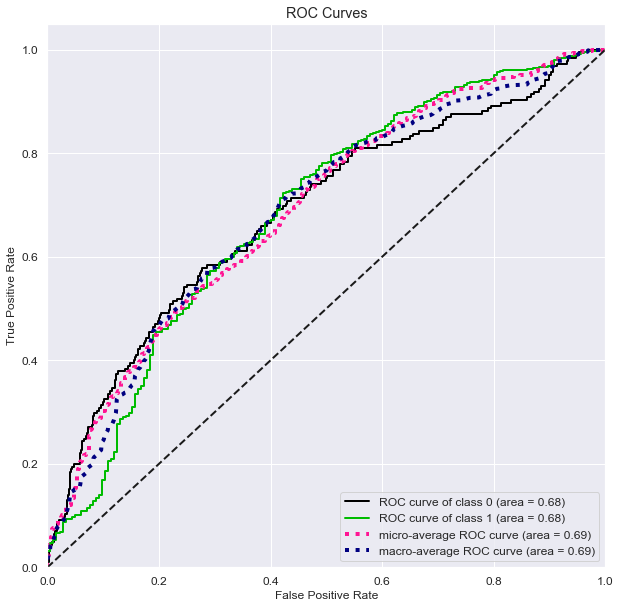

<Figure size 1152x1152 with 0 Axes>

In [85]:
y_true = res['status']
y_probas = lr4.predict_proba(new_X_test_upsampled_scaled)
skplt.metrics.plot_roc(y_true, y_probas, figsize=(10,10))
plt.show();
plt.savefig('graphs/roc_auc.png')

<div style="float:left"><a href="#TOC">Table of contents</a></div>
<a name="coef"></a>

### Model's coefficients

In [86]:
features = get_df_coef(lr4, new_X_test_upsampled_scaled)

In [87]:
features

,name,coef,abs_coef
13,overdraft_transactions,-0.004387,0.004387
23,title_loan,0.017187,0.017187
7,income_length,0.018970,0.018970
11,days_until_next_payroll,0.020503,0.020503
16,reverse_transactions,-0.021531,0.021531
4,government_aid_weekly_income,0.028080,0.028080
14,nsf_transactions,-0.029740,0.029740
6,large_deposits_weekly_income,-0.041926,0.041926
5,frequency_heuristic_weekly_income,0.049554,0.049554
2,atm_check_deposits_weekly_income,0.049773,0.049773


<div style="float:left"><a href="#TOC">Table of contents</a></div>
<a name="pred"></a>

# 8. Making predictions with lr4 model

In [88]:
test_application = (0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 20, 1000, 5, 0, 1, 0, 1, 500, 100, 300,
                    3, 100, 0, 300, 2000, 4, 1, 1, 500, 0, 0, 0)

In [89]:
with open('lr_model.sav', 'rb') as f:
    model = pickle.load(f)

with open('scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

In [90]:
prediction = predict_p(test_application, model, scaler)
print(prediction)

[[0.06276169 0.93723831]]


<div style="float:left"><a href="#TOC">Table of contents</a></div>
<a name="check_calib"></a>

# 9. Checking lr4 model's calibation

<div style="float:left"><a href="#TOC">Table of contents</a></div>
<a name="calib"></a>

### Check model's calibration of training and testing set

In [91]:
#check calibration of the test set
res = predict_probability_and_class(lr4, new_X_test_upsampled_scaled, y_test, 0.25)
check_calibration(res)

              precision    recall  f1-score   support

           0       0.23      0.92      0.37       185
           1       0.84      0.12      0.20       644

    accuracy                           0.30       829
   macro avg       0.54      0.52      0.29       829
weighted avg       0.71      0.30      0.24       829



[(0.9583333333333334, '0 - 0.1', 24),
 (0.8888888888888888, '0.1 - 0.2', 36),
 (0.7941176470588235, '0.2 - 0.3', 68),
 (0.9022556390977443, '0.3 -0.4', 133),
 (0.8402061855670103, '0.4 - 0.5', 194),
 (0.7657657657657657, '0.5 - 0,6', 222),
 (0.57, '0.6 - 0.7', 100),
 (0.5111111111111111, '0.7 - 0.8', 45),
 (0.16666666666666666, '0.8 - 0.9', 6),
 (1.0, '0.9 - 1', 1)]

In [92]:
#check calibration on train test:
res = predict_probability_and_class(lr4, new_X_train_upsampled_scaled, new_y_train_upsampled, 0.25)
check_calibration(res)

              precision    recall  f1-score   support

           0       0.53      0.97      0.68      2642
           1       0.83      0.13      0.23      2671

    accuracy                           0.55      5313
   macro avg       0.68      0.55      0.45      5313
weighted avg       0.68      0.55      0.45      5313



[(0.9545454545454546, '0 - 0.1', 132),
 (0.8164556962025317, '0.1 - 0.2', 158),
 (0.7455830388692579, '0.2 - 0.3', 283),
 (0.6471518987341772, '0.3 -0.4', 632),
 (0.562255285826155, '0.4 - 0.5', 1277),
 (0.44385382059800665, '0.5 - 0,6', 1505),
 (0.35023041474654376, '0.6 - 0.7', 868),
 (0.25745257452574527, '0.7 - 0.8', 369),
 (0.12987012987012986, '0.8 - 0.9', 77),
 (0.08333333333333333, '0.9 - 1', 12)]

<div style="float:left"><a href="#TOC">Table of contents</a></div>
<a name="cv_calib"></a>

### Cross-validate calibration of lr4 model

In [93]:
avgs = cv_calibration(new_X_train_upsampled_scaled, new_X_test_upsampled_scaled, new_y_train_upsampled, y_test)

              precision    recall  f1-score   support

           0       0.22      0.97      0.36       250
           1       0.94      0.12      0.21       979

    accuracy                           0.29      1229
   macro avg       0.58      0.54      0.28      1229
weighted avg       0.79      0.29      0.24      1229

              precision    recall  f1-score   support

           0       0.20      0.98      0.34       227
           1       0.96      0.13      0.23      1002

    accuracy                           0.29      1229
   macro avg       0.58      0.55      0.28      1229
weighted avg       0.82      0.29      0.25      1229

              precision    recall  f1-score   support

           0       0.47      0.96      0.63       538
           1       0.82      0.14      0.24       690

    accuracy                           0.50      1228
   macro avg       0.64      0.55      0.43      1228
weighted avg       0.66      0.50      0.41      1228

              preci

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [94]:
# Warning explanation: for some ranges of probability there are no applications, 
# so this is why the above warning appeared.

In [95]:
#Averages true classes for predicted P ranges 0-0.1 to 0.9-1
print(avgs)

[0.7512120669056153, 0.7169380796508456, 0.6605320173041692, 0.6355672692870717, 0.5477953598102852, 0.4986846135434691, 0.4133785336075871, 0.36123041686613533, 0.30265151515151517, nan]


<div style="float:left"><a href="#TOC">Table of contents</a></div>
<a name="plot_calib"></a>

### Plot cross-validated calibration

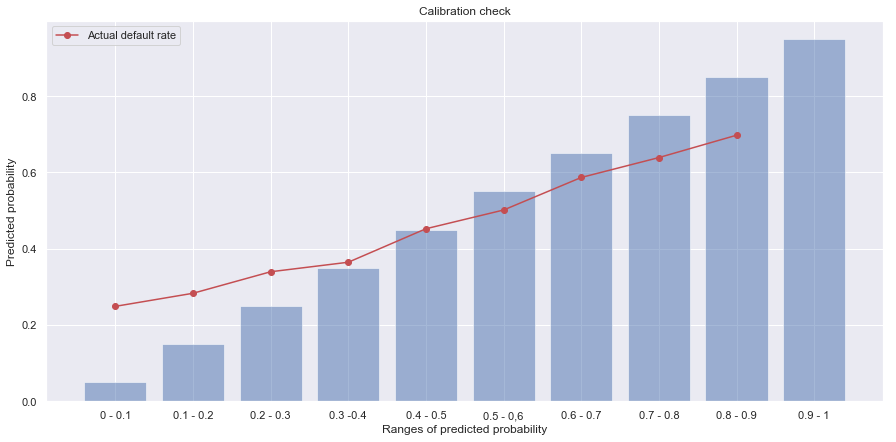

<Figure size 1152x1152 with 0 Axes>

In [96]:
ranges = ['0 - 0.1', '0.1 - 0.2', '0.2 - 0.3', '0.3 -0.4', '0.4 - 0.5', '0.5 - 0,6',
           '0.6 - 0.7', '0.7 - 0.8', '0.8 - 0.9', '0.9 - 1']
avg_ranges = [0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95]
means = [(1-avgs[0]), (1-avgs[1]), (1-avgs[2]), (1-avgs[3]), (1-avgs[4]), (1-avgs[5]), 
         (1-avgs[6]), (1-avgs[7]), (1-avgs[8]), (1-avgs[9])]
plt.figure(figsize=(15, 7))
plt.bar(ranges, avg_ranges, align='center', alpha=0.5)
plt.plot(means, 'r', marker='o')
plt.legend(['Actual default rate'])
plt.ylabel('Predicted probability')
plt.xlabel('Ranges of predicted probability')
plt.title('Calibration check')

plt.show()
plt.savefig('graphs/calibration_check.png')

#### There are not a lot of observations in 0.9 - 1 range comparing to the other ranges, that might explain that predicted and actual probability don't match